<a href="https://colab.research.google.com/github/Devika532/ML-Volatility-GP-Project/blob/Task1_code/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 1: Install and import yfinance, download S&P 500 (^GSPC) data

!pip install yfinance --quiet

import yfinance as yf
import pandas as pd

# Download daily data for S&P 500 from 2010-01-01 to today
data = yf.download("^GSPC", start="2010-01-01", progress=False)

# Reset index so Date is a column
data = data.reset_index()

print("Data shape:", data.shape)
print(data.head())


/tmp/ipython-input-976159255.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^GSPC", start="2010-01-01", progress=False)


Data shape: (4010, 6)
Price        Date        Close         High          Low         Open  \
Ticker                   ^GSPC        ^GSPC        ^GSPC        ^GSPC   
0      2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059   
1      2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034   
2      2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961   
3      2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020   
4      2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020   

Price       Volume  
Ticker       ^GSPC  
0       3991400000  
1       2491020000  
2       4972660000  
3       5270680000  
4       4389590000  


In [2]:
# STEP 2: Clean column names and prepare the dataframe

# Flatten column names if multi-index
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[-1] for col in data.columns]

# Ensure we have simple column names
data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# Convert Date to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort rows just in case
data = data.sort_values('Date').reset_index(drop=True)

print("Cleaned data shape:", data.shape)
print(data.head())
print("\nColumns:", data.columns)


Cleaned data shape: (4010, 6)
        Date        Close         High          Low         Open      Volume
0 2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059  3991400000
1 2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034  2491020000
2 2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961  4972660000
3 2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020  5270680000
4 2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020  4389590000

Columns: Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [4]:
# STEP 3: Feature Engineering

import numpy as np

df = data.copy()

# --- Daily returns ---
df['Return'] = df['Close'].pct_change()

# --- Log returns (more statistically stable) ---
df['LogReturn'] = np.log1p(df['Return'])

# --- Rolling volatility (20-day window, annualised) ---
vol_window = 20
df['RollingVol'] = df['LogReturn'].rolling(vol_window).std() * np.sqrt(252)

# --- Moving averages ---
df['MA_10'] = df['Close'].rolling(10).mean()
df['MA_20'] = df['Close'].rolling(20).mean()

# --- Momentum (5-day price change) ---
df['Mom_5'] = df['Close'].pct_change(5)

# --- High–Low Range as intraday volatility ---
df['HL_Range'] = (df['High'] - df['Low']) / df['Close']

# --- Volume moving average + change ---
df['Vol_MA_10'] = df['Volume'].rolling(10).mean()
df['Vol_Change'] = df['Volume'].pct_change()

# --- Regression target: next-day volatility ---
df['TargetVol'] = df['RollingVol'].shift(-1)

# Drop rows with missing values due to rolling windows
df_features = df.dropna().reset_index(drop=True)

print("Feature-engineered dataset shape:", df_features.shape)
df_features.head(10)


Feature-engineered dataset shape: (3989, 16)


,Date,Close,High,Low,Open,Volume,Return,LogReturn,RollingVol,MA_10,MA_20,Mom_5,HL_Range,Vol_MA_10,Vol_Change,TargetVol
0,2010-02-02,1103.319946,1104.729980,1087.959961,1090.050049,4749540000,0.012973,0.012890,0.166376,1098.364001,1120.378497,0.010209,0.015200,5.211832e+09,0.164785,0.166134
1,2010-02-03,1097.280029,1102.719971,1093.969971,1100.670044,4285450000,-0.005474,-0.005489,0.166134,1094.288000,1118.416498,-0.000200,0.007974,5.159321e+09,-0.097713,0.196683
2,2010-02-04,1063.109985,1097.250000,1062.780029,1097.250000,5859690000,-0.031141,-0.031636,0.196683,1088.951001,1114.714996,-0.019751,0.032424,5.057861e+09,0.367345,0.196175
3,2010-02-05,1066.189941,1067.130005,1044.500000,1064.119995,6438900000,0.002897,0.002893,0.196175,1086.393994,1110.939996,-0.007152,0.021225,5.080886e+09,0.098847,0.195615
4,2010-02-08,1056.739990,1071.199951,1056.510010,1065.510010,4089820000,-0.008863,-0.008903,0.195615,1082.389990,1106.527997,-0.029793,0.013901,5.041729e+09,-0.364826,0.203863
5,2010-02-09,1070.520020,1079.280029,1060.060059,1060.060059,5114260000,0.013040,0.012956,0.203863,1080.224988,1102.704999,-0.029728,0.017954,5.079964e+09,0.250485,0.202661
6,2010-02-10,1068.130005,1073.670044,1059.339966,1069.680054,4251450000,-0.002233,-0.002235,0.202661,1077.287988,1099.300500,-0.026566,0.013416,4.973197e+09,-0.168707,0.203715
7,2010-02-11,1078.469971,1080.040039,1060.589966,1067.099976,4400870000,0.009680,0.009634,0.203715,1076.681982,1095.939996,0.014448,0.018035,4.868044e+09,0.035146,0.202705
8,2010-02-12,1075.510010,1077.810059,1062.969971,1075.949951,4160680000,-0.002745,-0.002748,0.202705,1076.845984,1092.292499,0.008741,0.013798,4.742827e+09,-0.054578,0.213760
9,2010-02-16,1094.869995,1095.670044,1079.130005,1079.130005,4080770000,0.018001,0.017841,0.213760,1077.413989,1090.234497,0.036083,0.015107,4.743143e+09,-0.019206,0.208419


In [5]:
# STEP 4: Create classification labels based on volatility threshold

# Regression target is already created: df_features['TargetVol']
y_reg = df_features['TargetVol'].values

# Classification target: high-risk if target volatility is above 75th percentile
vol_threshold = np.quantile(y_reg, 0.75)
df_features['RiskLabel'] = (df_features['TargetVol'] > vol_threshold).astype(int)

y_clf = df_features['RiskLabel'].values

print("Volatility threshold used for classification:", vol_threshold)
print("\nClass distribution (0 = Low Risk, 1 = High Risk):")
print(df_features['RiskLabel'].value_counts())


Volatility threshold used for classification: 0.17478358167431382

Class distribution (0 = Low Risk, 1 = High Risk):
RiskLabel
0    2992
1     997
Name: count, dtype: int64


In [7]:
# FIX: Replace infinite values and drop remaining NaNs before scaling

df_features_clean = df_features.replace([np.inf, -np.inf], np.nan)
df_features_clean = df_features_clean.dropna().reset_index(drop=True)

print("Cleaned feature matrix shape:", df_features_clean.shape)

# Recreate inputs with cleaned data
X = df_features_clean[feature_cols].values
y_reg = df_features_clean['TargetVol'].values
y_clf = df_features_clean['RiskLabel'].values
dates = df_features_clean['Date'].values

# Time-based split again
n = len(df_features_clean)
train_end = int(0.8 * n)

X_train = X[:train_end]
X_test  = X[train_end:]

y_reg_train = y_reg[:train_end]
y_reg_test  = y_reg[train_end:]

y_clf_train = y_clf[:train_end]
y_clf_test  = y_clf[train_end:]

dates_train = dates[:train_end]
dates_test  = dates[train_end:]

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

# Scale safely now
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaling successful. Example scaled row:")
print(X_train_scaled[0])


Cleaned feature matrix shape: (3988, 17)
Train size: 3190
Test size : 798

Scaling successful. Example scaled row:
[ 1.12039271  0.18409198 -1.3128239  -1.28730255  0.35144112  0.46958869
  1.67266502  0.74019766]


In [8]:
# STEP 6: Gaussian Process Regression with Multiple Kernels

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

gp_reg_results = {}

# Define candidate kernels
kernel_rbf = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0) + WhiteKernel()
kernel_matern = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=1.5) + WhiteKernel()
kernel_rq = ConstantKernel(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=1.0) + WhiteKernel()

kernels = {
    "RBF": kernel_rbf,
    "Matern": kernel_matern,
    "RationalQuadratic": kernel_rq
}

print("=== Training Gaussian Process Regression Models ===\n")

for name, kernel in kernels.items():
    print(f"Training kernel: {name}")

    gp = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=3,
        normalize_y=True,
        random_state=42
    )

    # Fit model
    gp.fit(X_train_scaled, y_reg_train)

    # Predict with uncertainty
    y_pred_mean, y_pred_std = gp.predict(X_test_scaled, return_std=True)

    # Metrics
    mse = mean_squared_error(y_reg_test, y_pred_mean)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_reg_test, y_pred_mean)
    r2 = r2_score(y_reg_test, y_pred_mean)

    # Store results
    gp_reg_results[name] = {
        "model": gp,
        "mean": y_pred_mean,
        "std": y_pred_std,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "kernel_fit": gp.kernel_
    }

    # Print summary
    print(f" → Fitted Kernel: {gp.kernel_}")
    print(f" → RMSE: {rmse:.6f}")
    print(f" → MAE:  {mae:.6f}")
    print(f" → R²:   {r2:.4f}\n")

print("\n=== Regression Complete ===")


=== Training Gaussian Process Regression Models ===

Training kernel: RBF
 → Fitted Kernel: 4.34**2 * RBF(length_scale=9.88) + WhiteKernel(noise_level=0.00983)
 → RMSE: 0.017940
 → MAE:  0.010557
 → R²:   0.9401

Training kernel: Matern


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


 → Fitted Kernel: 31.6**2 * Matern(length_scale=128, nu=1.5) + WhiteKernel(noise_level=0.00828)
 → RMSE: 0.013850
 → MAE:  0.008224
 → R²:   0.9643

Training kernel: RationalQuadratic


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 → Fitted Kernel: 13**2 * RationalQuadratic(alpha=0.0311, length_scale=44) + WhiteKernel(noise_level=0.0094)
 → RMSE: 0.015529
 → MAE:  0.009384
 → R²:   0.9551


=== Regression Complete ===


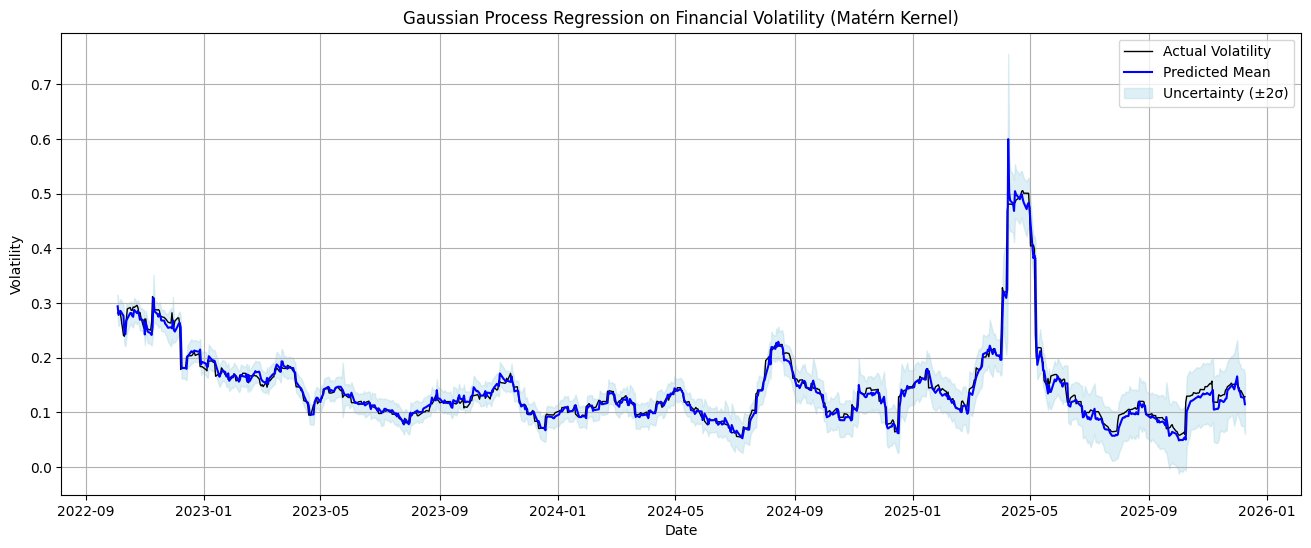

In [9]:
# STEP 7: Plot GP Regression Uncertainty (Using Best Kernel: Matérn)

import matplotlib.pyplot as plt

best_kernel_name = "Matern"
best_model = gp_reg_results[best_kernel_name]["model"]
y_mean = gp_reg_results[best_kernel_name]["mean"]
y_std = gp_reg_results[best_kernel_name]["std"]

# Convert std to upper and lower bounds
upper = y_mean + 2 * y_std
lower = y_mean - 2 * y_std

plt.figure(figsize=(16,6))
plt.plot(dates_test, y_reg_test, label="Actual Volatility", color="black", linewidth=1)
plt.plot(dates_test, y_mean, label="Predicted Mean", color="blue")
plt.fill_between(dates_test, lower, upper, color="lightblue", alpha=0.4, label="Uncertainty (±2σ)")
plt.title("Gaussian Process Regression on Financial Volatility (Matérn Kernel)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# STEP 8: Gaussian Process Classification (High vs Low Risk)

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Use the best regression kernel structure as the base kernel for classification
best_kernel = gp_reg_results["Matern"]["kernel_fit"].k1  # strip noise

gp_clf = GaussianProcessClassifier(
    kernel=best_kernel,
    n_restarts_optimizer=2,
    random_state=42
)

print("Training GP Classification (this is much faster than regression)...")
gp_clf.fit(X_train_scaled, y_clf_train)

# Predict
y_pred_clf = gp_clf.predict(X_test_scaled)
y_prob_clf = gp_clf.predict_proba(X_test_scaled)[:, 1]  # probability of high risk

# Performance
acc = accuracy_score(y_clf_test, y_pred_clf)
cm = confusion_matrix(y_clf_test, y_pred_clf)

print("\n=== GP Classification Results ===")
print("Accuracy:", acc)
print("\nConfusion Matrix (rows = true, cols = predicted):\n", cm)
print("\nClassification Report:\n", classification_report(y_clf_test, y_pred_clf))


Training GP Classification (this is much faster than regression)...


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



=== GP Classification Results ===
Accuracy: 0.9799498746867168

Confusion Matrix (rows = true, cols = predicted):
 [[632   8]
 [  8 150]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       640
           1       0.95      0.95      0.95       158

    accuracy                           0.98       798
   macro avg       0.97      0.97      0.97       798
weighted avg       0.98      0.98      0.98       798

